In [139]:
# install requirements
!pip install -r ../requirements.txt



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
# import packages
import pandas as pd
from tqdm import tqdm
from meteostat import Point, Daily
from datetime import datetime, timedelta
import os   
import shutil
import kagglehub
import holidays
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub

/Users/harish/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Download Kaggle Dataset
this contains 3 million rows,
- We will just use one year of data, so from 31-07-2024 onwards

In [8]:
import kagglehub

# Download to cache
path = kagglehub.dataset_download("patrickzel/flight-delay-and-cancellation-dataset-2019-2023")

# Choose your desired location
target_dir = "../data/raw"  # relative to your project
os.makedirs(target_dir, exist_ok=True)

# Copy all downloaded files
for file in os.listdir(path):
    shutil.copy(os.path.join(path, file), os.path.join(target_dir, file))

print("Dataset copied to:", target_dir)

Dataset copied to: ../data/raw


In [101]:
pd.max_columns = 99  # Show all columns in DataFrame  
pd.max_rows = 99  # Show all rows in DataFrame

In [ ]:
df = pd.read_csv("../data/raw/flights_sample_3m.csv")


InvalidIndexError: (slice(None, None, None), -15)

In [109]:
# show last 15 columns where arr_dleay is greater than 0    
len(df[df["ARR_DELAY"] > 60].iloc[:, -15:])


175135

In [98]:
df.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT'],
      dtype='object')

In [110]:
# load and filter dataset for rows after 31-07-2024
df_reduced = df[df['FL_DATE'] >= '2021-07-31']
df.shape, df_reduced.shape

((3000000, 32), (1437770, 32))

In [111]:
## Now save this back
df_reduced.to_csv("../data/raw/flights_sample_reduced.csv", index=True)

In [53]:
# functiont o do this # load and filter dataset for rows after 31-07-2024
def load_and_filter_dataset(file_path, start_date):
    """Loads the dataset and filters for rows after selected date."""
    df = pd.read_csv(file_path)
    df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])
    filtered_df = df[df["FL_DATE"] >= start_date]
    return filtered_df

In [56]:
df_reduced = load_and_filter_dataset("../data/raw/flights_sample_3m.csv","2022-07-31" )

## Now begin exploring the data

In [57]:
df_reduced.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
6,2023-06-11,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2134,DCA,"Washington, DC",BOS,"Boston, MA",...,0.0,109.0,89.0,58.0,399.0,NaN,NaN,NaN,NaN,NaN
8,2023-02-12,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,590,IAH,"Houston, TX",LAX,"Los Angeles, CA",...,0.0,227.0,219.0,200.0,1379.0,NaN,NaN,NaN,NaN,NaN
22,2022-11-12,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2706,GRR,"Grand Rapids, MI",MSP,"Minneapolis, MN",...,0.0,96.0,76.0,61.0,408.0,NaN,NaN,NaN,NaN,NaN


In [58]:
# examine the columns
df_reduced.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT'],
      dtype='object')

## Here we use openflight to get data about airports such as long/ lat to enable mapping to weather data later
- first we svae this locally and then convert from .dat to csv

In [170]:
# OpenFlights columns
cols = [
    "airport_id","name","city","country","IATA","ICAO",
    "lat","lon","alt","timezone","dst","tz_db","type","source"
]
air = pd.read_csv("../test_data/data/raw/airports.dat", names=cols)

# Keep only needed columns & drop bad rows
air = air[["IATA","ICAO","name","lat","lon","tz_db"]]
air = air.dropna(subset=["IATA","lat","lon","tz_db"])
air = air[air["IATA"] != "\\N"].drop_duplicates("IATA")

# Save cleaned CSV
air.to_csv("../data/raw/airports.csv", index=False)

print(f"Saved {len(air)} airports to data/raw/airports.csv")

Saved 6072 airports to data/raw/airports.csv


In [59]:
# we dont want diverted or cancelled flights
def removed_diverted_or_cancelled(df):
    """
    Remove diverted or cancelled flights from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing flight data.
    
    Returns:
    pd.DataFrame: Filtered DataFrame with diverted and cancelled flights removed.
    """
    return df[(df['DIVERTED'] == 0) & (df['CANCELLED'] == 0)]


In [60]:
df = removed_diverted_or_cancelled(df_reduced)
df.shape

(738053, 32)

In [61]:
# now we want to create a delay flag for 15 and 30 minutes delay
def create_delay_flag(df, delay_threshold=30):
    """
    Create a delay flag based on the specified delay threshold.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing flight data.
    delay_threshold (int): Delay threshold in minutes to flag as delayed.
    
    Returns:
    pd.DataFrame: DataFrame with an additional 'DELAY_FLAG' column.
    """
    df[f'DELAY_FLAG_{delay_threshold}'] = df['ARR_DELAY'].apply(lambda x: 1 if x >= delay_threshold else 0)
    return df

In [62]:
df = create_delay_flag(df, delay_threshold=30)

In [63]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DELAY_FLAG_30
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN,0
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0,0
6,2023-06-11,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2134,DCA,"Washington, DC",BOS,"Boston, MA",...,109.0,89.0,58.0,399.0,NaN,NaN,NaN,NaN,NaN,0
8,2023-02-12,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,590,IAH,"Houston, TX",LAX,"Los Angeles, CA",...,227.0,219.0,200.0,1379.0,NaN,NaN,NaN,NaN,NaN,0
22,2022-11-12,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2706,GRR,"Grand Rapids, MI",MSP,"Minneapolis, MN",...,96.0,76.0,61.0,408.0,NaN,NaN,NaN,NaN,NaN,0


In [64]:
# check class balance
df['DELAY_FLAG_30'].value_counts(normalize=True)

DELAY_FLAG_30
0    0.859007
1    0.140993
Name: proportion, dtype: float64

## Now we will add the weather data
we will use meteosat
✈️ Flight Weather Enrichment Pipeline — High-Level Steps

1. Input & Requirements
	•	Takes a flights dataset (BTS-style) with:
	•	FL_DATE, ORIGIN, DEST, CRS_DEP_TIME, CRS_ARR_TIME
	•	Needs an airports CSV mapping IATA codes → latitude & longitude.

⸻

2. Create Local Time Keys
	•	Convert CRS_DEP_TIME & CRS_ARR_TIME (HHMM format) into hourly timestamps in local flight date.
	•	Two keys created:
	•	dep_hour_dt → planned departure hour
	•	arr_hour_dt → planned arrival hour

⸻

3. Build Unique Weather Requests
	•	Combine all (airport, hour) pairs from dep & arr flights.
	•	Extract year from each timestamp.
	•	Build a list of (IATA, year) pairs → minimum needed weather calls.

⸻

4. Fetch & Cache Raw Weather Data
	•	For each (IATA, year):
	1.	Check local cache (weather_cache/IATA_YEAR_RAW.parquet).
	2.	If cached → load it.
	3.	If not:
	•	Use Meteostat Hourly API to fetch:
	•	temp (°C), prcp (mm), wspd (km/h)
	•	Save raw data to cache (keeps API usage low).
	•	Uses multi-threading to fetch multiple airports in parallel.
	•	Shows a progress bar while fetching.

⸻

5. Compute Weather Flags

From the raw weather data, create binary flags:
	•	rain → precipitation > 0
	•	ice  → temperature ≤ 0°C and precipitation > 0
	•	wind → wind speed ≥ wind_kmh_threshold (user-configurable)

Because the cache stores raw data, you can change the threshold and recompute without re-fetching.

⸻

6. Merge Weather into Flights
	•	For departures: join on (ORIGIN, dep_hour_dt)
	•	For arrivals: join on (DEST, arr_hour_dt)
	•	Add:
	•	dep_rain, dep_ice, dep_wind
	•	arr_rain, arr_ice, arr_wind
	•	Also add *_missing flags to mark where weather data wasn’t available.

⸻

7. Output
	•	Returns the original flights DataFrame with 6 weather flags + 6 missing flags added.
	•	Efficient (fetches once per airport/year), reusable (cache), and configurable.

⸻

In [65]:
# ========= Weather Enrichment (helpers + orchestrator) =========

import warnings
warnings.simplefilter("ignore")  # silence pandas FutureWarnings

from pathlib import Path
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd
from meteostat import Hourly, Point
from tqdm.auto import tqdm


# ----------------------------- #
# Low-level helpers (pure funcs)
# ----------------------------- #

def _hhmm_to_hour(x) -> int:
    """Convert HHMM-ish values (930, 0930, '1730', 930.0) to an integer hour [0..23]."""
    if pd.isna(x):
        return 0
    s = str(int(float(x))).zfill(4)[:4]
    return int(s[:2])


def _add_hour_keys(df: pd.DataFrame) -> pd.DataFrame:
    """Add dep_hour_dt / arr_hour_dt columns (local-date + hour buckets)."""
    out = df.copy()
    out["FL_DATE"] = pd.to_datetime(out["FL_DATE"])
    dep_h = out["CRS_DEP_TIME"].apply(_hhmm_to_hour)
    arr_h = out["CRS_ARR_TIME"].apply(_hhmm_to_hour)
    out["dep_hour_dt"] = pd.to_datetime(out["FL_DATE"].dt.date) + pd.to_timedelta(dep_h, unit="h")
    out["arr_hour_dt"] = pd.to_datetime(out["FL_DATE"].dt.date) + pd.to_timedelta(arr_h, unit="h")
    return out


def _validate_flights(df_flights: pd.DataFrame) -> None:
    """Ensure flights DF has the required columns."""
    required = {"FL_DATE", "ORIGIN", "DEST", "CRS_DEP_TIME", "CRS_ARR_TIME"}
    missing = required - set(df_flights.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")


def _load_airports(airports_csv: str) -> pd.DataFrame:
    """Load airports CSV (must include IATA, lat, lon). Returns DF indexed by IATA with ['lat','lon']."""
    ap = pd.read_csv(airports_csv)
    need = {"IATA", "lat", "lon"}
    miss = need - set(ap.columns)
    if miss:
        raise ValueError(f"Airports CSV must contain columns: {need}. Missing: {miss}")
    ap = ap.dropna(subset=["IATA", "lat", "lon"]).drop_duplicates("IATA").set_index("IATA")[["lat", "lon"]]
    return ap


def _build_needed_pairs(df: pd.DataFrame, ap: pd.DataFrame) -> pd.DataFrame:
    """From flights with hour keys, build unique (IATA, year) pairs and attach lat/lon."""
    dep_keys = df[["ORIGIN", "dep_hour_dt"]].rename(columns={"ORIGIN": "IATA", "dep_hour_dt": "ts"})
    arr_keys = df[["DEST", "arr_hour_dt"]].rename(columns={"DEST": "IATA", "arr_hour_dt": "ts"})
    all_keys = pd.concat([dep_keys, arr_keys], ignore_index=True).dropna().drop_duplicates()
    all_keys["year"] = all_keys["ts"].dt.year
    pairs = all_keys[["IATA", "year"]].drop_duplicates().join(ap, on="IATA", how="inner")
    return pairs


def _fetch_airport_year_raw(iata: str, lat: float, lon: float, year: int,
                            cache_dir: Path, force_refresh: bool=False) -> pd.DataFrame:
    """
    Fetch RAW hourly weather for one (airport, year) from Meteostat.
    Caches to Parquet as {IATA}_{year}_RAW.parquet with columns: ts, prcp, temp, wspd, IATA
    """
    cache_dir.mkdir(parents=True, exist_ok=True)
    fpath = cache_dir / f"{iata}_{year}_RAW.parquet"

    if (not force_refresh) and fpath.exists():
        return pd.read_parquet(fpath)

    p = Point(float(lat), float(lon))
    start = datetime(int(year), 1, 1)
    end   = datetime(int(year), 12, 31, 23, 59, 59)

    wx = Hourly(p, start, end).fetch()  # index 'time' (UTC, hourly)
    if wx.empty:
        raw = pd.DataFrame(columns=["ts", "prcp", "temp", "wspd", "IATA"])
    else:
        raw = wx.reset_index().rename(columns={"time": "ts"})
        raw = raw[["ts", "prcp", "temp", "wspd"]]
        raw["IATA"] = iata

    raw.to_parquet(fpath, index=False)
    return raw


def _fetch_all_raw_with_progress(pairs: pd.DataFrame, cache_dir: Path,
                                 max_workers: int, force_refresh: bool) -> pd.DataFrame:
    """Parallel fetch raw weather for all (IATA, year) pairs with a progress bar."""
    parts = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {
            ex.submit(_fetch_airport_year_raw, r.IATA, r.lat, r.lon, int(r.year), cache_dir, force_refresh): (r.IATA, int(r.year))
            for r in pairs.itertuples(index=False)
        }
        for fut in tqdm(as_completed(futures), total=len(futures), desc="Fetching Meteostat raw (airport-year)"):
            parts.append(fut.result())

    if parts:
        out = pd.concat(parts, ignore_index=True)
        out.drop_duplicates(subset=["IATA", "ts"], inplace=True)
        return out
    return pd.DataFrame(columns=["ts", "prcp", "temp", "wspd", "IATA"])


def _compute_flags_from_raw(raw_df: pd.DataFrame, wind_kmh_threshold: int) -> pd.DataFrame:
    """
    Compute binary flags from raw weather:
      rain = prcp > 0
      ice  = temp <= 0 and prcp > 0
      wind = wspd >= threshold
    Returns: ['ts','rain','ice','wind','IATA']
    """
    if raw_df.empty:
        return pd.DataFrame(columns=["ts", "rain", "ice", "wind", "IATA"])

    out = raw_df.copy()
    out["rain"] = (out["prcp"].fillna(0) > 0).astype("int8")
    out["ice"]  = ((out["temp"].fillna(99) <= 0) & (out["prcp"].fillna(0) > 0)).astype("int8")
    out["wind"] = (out["wspd"].fillna(0) >= wind_kmh_threshold).astype("int8")
    return out[["ts", "rain", "ice", "wind", "IATA"]]


def _merge_flags(df: pd.DataFrame, wx_flags: pd.DataFrame) -> pd.DataFrame:
    """Merge dep/arr flags into flights by (IATA, hour-key) and add *_missing columns."""
    # Departure merge
    dep = (
        df[["ORIGIN", "dep_hour_dt"]]
        .rename(columns={"ORIGIN": "IATA", "dep_hour_dt": "ts"})
        .merge(wx_flags, on=["IATA", "ts"], how="left")
        .rename(columns={"rain": "dep_rain", "ice": "dep_ice", "wind": "dep_wind"})
    )
    # Arrival merge
    arr = (
        df[["DEST", "arr_hour_dt"]]
        .rename(columns={"DEST": "IATA", "arr_hour_dt": "ts"})
        .merge(wx_flags, on=["IATA", "ts"], how="left")
        .rename(columns={"rain": "arr_rain", "ice": "arr_ice", "wind": "arr_wind"})
    )

    out = df.copy()
    out["dep_rain"], out["dep_ice"], out["dep_wind"] = dep["dep_rain"].values, dep["dep_ice"].values, dep["dep_wind"].values
    out["arr_rain"], out["arr_ice"], out["arr_wind"] = arr["arr_rain"].values, arr["arr_ice"].values, arr["arr_wind"].values

    for col in ["dep_rain", "dep_ice", "dep_wind", "arr_rain", "arr_ice", "arr_wind"]:
        out[f"{col}_missing"] = out[col].isna().astype("int8")
        out[col] = out[col].fillna(0).astype("int8")

    return out


# ---------------------------------- #
# Orchestrator (public entry point)
# ---------------------------------- #

def enrich_with_weather_flags(
    df_flights: pd.DataFrame,
    airports_csv: str = "../data/raw/airports.csv",  # Must contain IATA, lat, lon
    cache_dir: str = "weather_cache",                # Where to save raw weather data
    wind_kmh_threshold: int = 30,                    # Wind speed threshold for "wind" flag
    max_workers: int = 12,                           # Parallel fetch threads
    force_refresh: bool = False                      # If True, ignore cache and re-download
) -> pd.DataFrame:
    """
    High-level pipeline:
      1) Validate inputs
      2) Add dep/arr hour keys
      3) Load airports & filter flights to known airports
      4) Build unique (IATA, year) fetch list
      5) Download (or load cached) RAW weather per airport-year
      6) Compute rain/ice/wind flags from RAW
      7) Merge flags back into flights
    """
    # 1) Validate
    _validate_flights(df_flights)

    # 2) Hour keys
    df_keyed = _add_hour_keys(df_flights)

    # 3) Airports & filter
    ap = _load_airports(airports_csv)
    df_keyed = df_keyed[df_keyed["ORIGIN"].isin(ap.index) & df_keyed["DEST"].isin(ap.index)].copy()

    # 4) Needed pairs
    pairs = _build_needed_pairs(df_keyed, ap)

    # 5) Fetch RAW with progress
    cache_path = Path(cache_dir)
    raw_weather = _fetch_all_raw_with_progress(pairs, cache_path, max_workers, force_refresh)

    # 6) Compute flags
    wx_flags = _compute_flags_from_raw(raw_weather, wind_kmh_threshold)

    # 7) Merge to flights
    df_enriched = _merge_flags(df_keyed, wx_flags)
    return df_enriched

In [66]:
df = enrich_with_weather_flags(
    df_flights=df,
    airports_csv="../data/raw/airports.csv",    # Path to airports CSV
    cache_dir="weather_cache",           # Cache directory for raw weather
    wind_kmh_threshold=30,                       # Wind speed threshold for "wind" flag
    max_workers=12,                              # Number of parallel fetch threads
    force_refresh=True                          # If True, ignore cache and re-download
)           

Fetching Meteostat raw (airport-year): 100%|██████████| 709/709 [00:35<00:00, 20.25it/s]


In [67]:
df.head() 

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,dep_wind,arr_rain,arr_ice,arr_wind,dep_rain_missing,dep_ice_missing,dep_wind_missing,arr_rain_missing,arr_ice_missing,arr_wind_missing
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,1,0,0,0,0,0,0,0,0,0
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0,0,0,0,0,0,0,0,0,0
6,2023-06-11,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2134,DCA,"Washington, DC",BOS,"Boston, MA",...,0,0,0,0,0,0,0,0,0,0
8,2023-02-12,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,590,IAH,"Houston, TX",LAX,"Los Angeles, CA",...,0,0,0,0,0,0,0,0,0,0
22,2022-11-12,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2706,GRR,"Grand Rapids, MI",MSP,"Minneapolis, MN",...,0,0,0,0,0,0,0,0,0,0


In [68]:
df.dep_rain.value_counts()  # Check for missing values in arr_wind

dep_rain
0    684135
1     53543
Name: count, dtype: int64

In [69]:
## look at percentages of flags
# List of weather flags
flags = ["dep_rain", "dep_ice", "dep_wind", "arr_rain", "arr_ice", "arr_wind"]

# Calculate counts and percentages
for col in flags:
    counts = df[col].value_counts().sort_index()
    total = counts.sum()
    pct = (counts / total * 100).round(2)
    
    print(f"\n{col}:")
    for val in counts.index:
        print(f"  {val}: {counts[val]} flights ({pct[val]}%)")


dep_rain:
  0: 684135 flights (92.74%)
  1: 53543 flights (7.26%)

dep_ice:
  0: 734171 flights (99.52%)
  1: 3507 flights (0.48%)

dep_wind:
  0: 718966 flights (97.46%)
  1: 18712 flights (2.54%)

arr_rain:
  0: 682990 flights (92.59%)
  1: 54688 flights (7.41%)

arr_ice:
  0: 734397 flights (99.56%)
  1: 3281 flights (0.44%)

arr_wind:
  0: 716563 flights (97.14%)
  1: 21115 flights (2.86%)


## We will now add some temporal features

In [70]:
def add_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add temporal features to the DataFrame:
      - day_of_week (0=Mon, 6=Sun)
      - month (1-12)
      - hour_of_day (0-23) from CRS_DEP_TIME
      - is_bank_holiday (US federal holiday)
    
    Parameters:
    df : pd.DataFrame
        DataFrame containing 'FL_DATE' and 'CRS_DEP_TIME' columns.
    
    Returns:
    pd.DataFrame : DataFrame with added columns.
    """
    df = df.copy()
    df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])

    # Day of week & month
    df["day_of_week"] = df["FL_DATE"].dt.dayofweek
    df["month"] = df["FL_DATE"].dt.month

    # Scheduled departure hour
    df["hour_of_day"] = df["CRS_DEP_TIME"].apply(
        lambda x: int(str(int(x)).zfill(4)[:2]) if pd.notnull(x) else 0
    )

    # US Bank Holidays
    start_year, end_year = df["FL_DATE"].dt.year.min(), df["FL_DATE"].dt.year.max()
    us_holidays = holidays.US(years=range(start_year, end_year + 1))
    df["is_bank_holiday"] = df["FL_DATE"].isin(us_holidays).astype("int8")

    return df

In [71]:
df = add_temporal_features(df)

In [72]:
df.head()


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,dep_rain_missing,dep_ice_missing,dep_wind_missing,arr_rain_missing,arr_ice_missing,arr_wind_missing,day_of_week,month,hour_of_day,is_bank_holiday
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0,0,0,0,0,0,5,11,21,0
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0,0,0,0,0,0,0,3,16,0
6,2023-06-11,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2134,DCA,"Washington, DC",BOS,"Boston, MA",...,0,0,0,0,0,0,6,6,10,0
8,2023-02-12,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,590,IAH,"Houston, TX",LAX,"Los Angeles, CA",...,0,0,0,0,0,0,6,2,5,0
22,2022-11-12,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2706,GRR,"Grand Rapids, MI",MSP,"Minneapolis, MN",...,0,0,0,0,0,0,5,11,7,0


In [185]:
df.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT', 'DELAY_FLAG_15', 'dep_hour_dt',
       'arr_hour_dt', 'dep_rain', 'dep_ice', 'dep_wind', 'arr_rain', 'arr_ice',
       'arr_wind', 'dep_rain_missing', 'dep_ice_missing', 'dep_wind_missing',
       'arr_rain_missing', 'arr_ice_missing', 'arr_wind_missing',
       'day_of_week', 'month', 'hour_of_day', 'is_bank_holiday'],
      dtype='object')

# Drop columns that arent needed
- such as those with information only available after flight

In [73]:
# drop columns that arent needed
# such as those with information only available after flight
# and columns that are clearly redundant like FL_DATE, CRS_DEP_TIME, CRS_ARR_TIME
cols_to_drop = [
            # Identifiers
            "FL_NUMBER",
            "AIRLINE_DOT",
            "AIRLINE_CODE",
            "DOT_CODE",
            # Location names (redundant with IATA codes)
            "ORIGIN_CITY",
            "DEST_CITY",
            # oout of scope / not useful for prediction
            "CRS_DEP_TIME",
            "CRS_ARR_TIME",
            "CRS_ELAPSED_TIME",
            "CANCELLED",
            "DIVERTED",
            "CRS_ELAPSED_TIME"
            # Future / leakage features
            "DEP_TIME",
            "DEP_DELAY",
            "TAXI_OUT",
            "WHEELS_OFF",
            "WHEELS_ON",
            "TAXI_IN",
            "ARR_TIME",
            "ARR_DELAY",
            "CANCELLATION_CODE",
            "ELAPSED_TIME",
            "AIR_TIME",
            "DELAY_DUE_CARRIER",
            "DELAY_DUE_WEATHER",
            "DELAY_DUE_NAS",
            "DELAY_DUE_SECURITY",
            "DELAY_DUE_LATE_AIRCRAFT",
            "DEP_TIME",
            # Raw datetime keys (already used to make features)
            "FL_DATE",
            "dep_hour_dt",
            "arr_hour_dt",
        ]
           

In [74]:
df_dropped = df.drop(columns=cols_to_drop, errors='ignore')

In [75]:
df_dropped.head()

,AIRLINE,ORIGIN,DEST,DISTANCE,DELAY_FLAG_30,dep_rain,dep_ice,dep_wind,arr_rain,arr_ice,...,dep_rain_missing,dep_ice_missing,dep_wind_missing,arr_rain_missing,arr_ice_missing,arr_wind_missing,day_of_week,month,hour_of_day,is_bank_holiday
1,Delta Air Lines Inc.,MSP,SEA,1399.0,0,0,0,1,0,0,...,0,0,0,0,0,0,5,11,21,0
3,Delta Air Lines Inc.,MSP,SFO,1589.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,16,0
6,American Airlines Inc.,DCA,BOS,399.0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,6,10,0
8,Spirit Air Lines,IAH,LAX,1379.0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,2,5,0
22,Delta Air Lines Inc.,GRR,MSP,408.0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,11,7,0


In [76]:
df_dropped.columns

Index(['AIRLINE', 'ORIGIN', 'DEST', 'DISTANCE', 'DELAY_FLAG_30', 'dep_rain',
       'dep_ice', 'dep_wind', 'arr_rain', 'arr_ice', 'arr_wind',
       'dep_rain_missing', 'dep_ice_missing', 'dep_wind_missing',
       'arr_rain_missing', 'arr_ice_missing', 'arr_wind_missing',
       'day_of_week', 'month', 'hour_of_day', 'is_bank_holiday'],
      dtype='object')

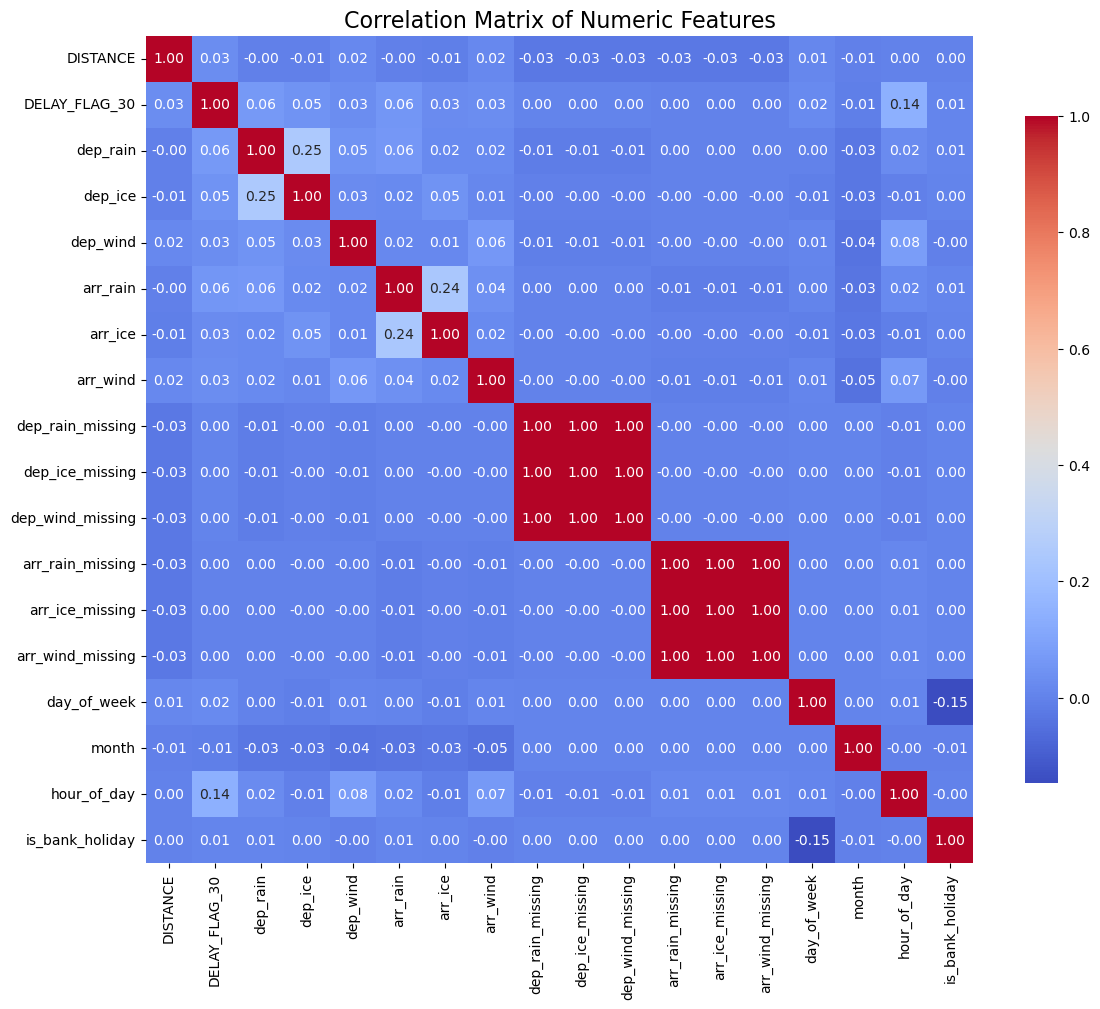

In [77]:
# Keep only numeric columns
numeric_df = df_dropped.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

In [78]:
df_dropped.drop(columns=[
    "dep_rain_missing",
    "dep_ice_missing",
    "dep_wind_missing",
    "arr_rain_missing",
    "arr_ice_missing",
    "arr_wind_missing"
], inplace=True)

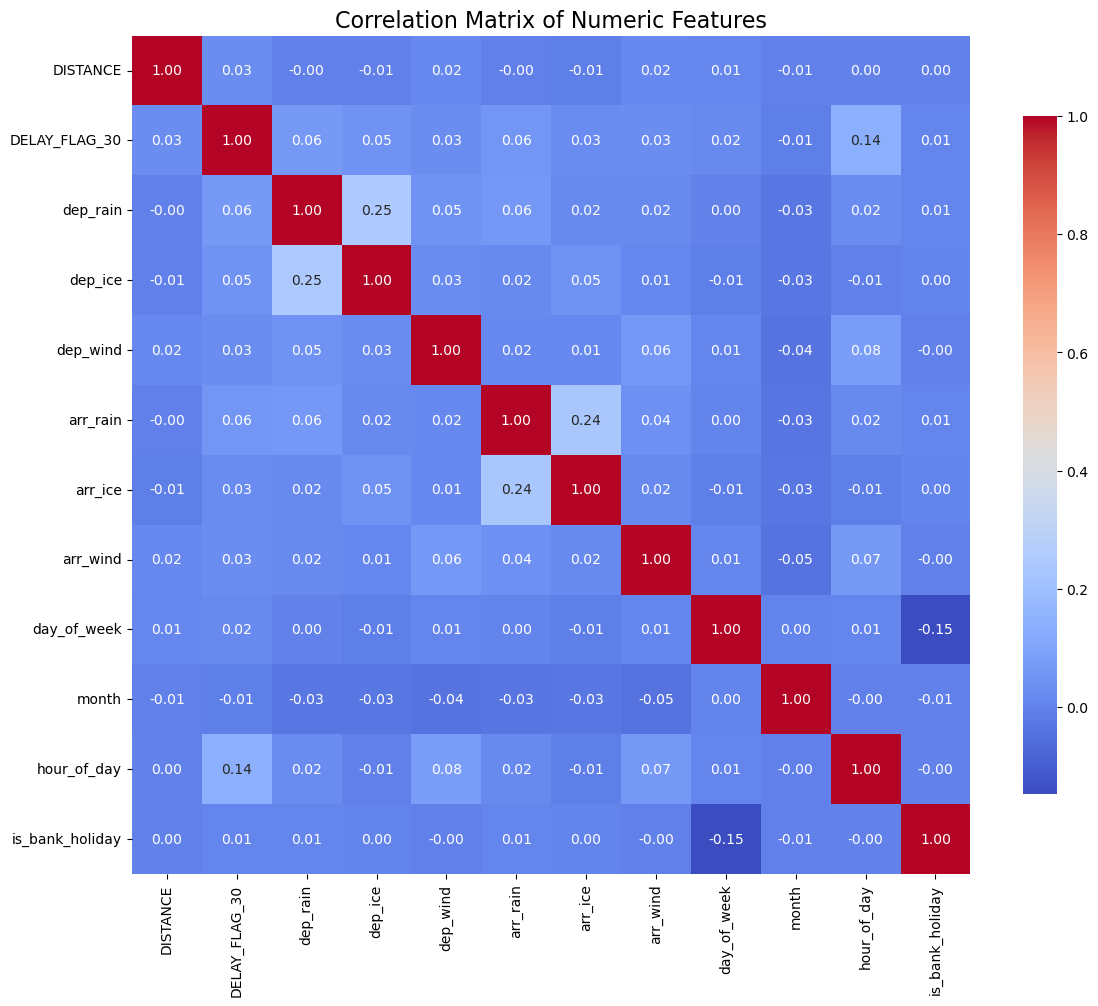

In [79]:
# Keep only numeric columns
numeric_df = df_dropped.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

# Save final data

In [20]:
os.makedirs(os.path.dirname("../test_data/data/processed/preprocessed_data.csv"), exist_ok=True)
df_dropped.to_csv("../test_data/data/processed/preprocessed_data.csv", index=False)
print(f"Preprocessed data saved to ../test_date/data/processed/preprocessed_data.csv")

Preprocessed data saved to ../test_date/data/processed/preprocessed_data.csv


In [80]:
# make directory if it does not exist
os.makedirs("../data/processed", exist_ok=True)
df_dropped.to_csv("../data/processed/preprocessed_data.csv", index=False)

In [111]:
df_test = pd.read_csv("/Users/harish/Desktop/Aero-delay-prediction/test_date/data/processed/preprocessed_data.csv")

In [93]:
df_test.head()

,AIRLINE,ORIGIN,DEST,DISTANCE,DELAY_FLAG_30,dep_rain,dep_ice,dep_wind,arr_rain,arr_ice,arr_wind,day_of_week,month,hour_of_day,is_bank_holiday
0,Delta Air Lines Inc.,MSP,SEA,1399.0,0,0,0,1,0,0,0,5,11,21,0
1,United Air Lines Inc.,DEN,MSP,680.0,0,0,0,0,0,0,0,4,7,9,0
2,Delta Air Lines Inc.,MSP,SFO,1589.0,0,0,0,0,0,0,0,0,3,16,0
3,American Airlines Inc.,DCA,BOS,399.0,0,0,0,0,0,0,0,6,6,10,0
4,Spirit Air Lines,IAH,LAX,1379.0,0,0,0,0,0,0,0,6,2,5,0


In [86]:
df_dropped.shape

(737678, 15)

In [112]:
df_test.shape

(2912367, 16)

In [113]:
## look at percentages of flags
# List of weather flags
flags = ["dep_rain", "dep_ice", "dep_wind", "arr_rain", "arr_ice", "arr_wind"]

# Calculate counts and percentages
for col in flags:
    counts = df_test[col].value_counts().sort_index()
    total = counts.sum()
    pct = (counts / total * 100).round(2)
    
    print(f"\n{col}:")
    for val in counts.index:
        print(f"  {val}: {counts[val]} flights ({pct[val]}%)")


dep_rain:
  0: 2704170 flights (92.85%)
  1: 208197 flights (7.15%)

dep_ice:
  0: 2897166 flights (99.48%)
  1: 15201 flights (0.52%)

dep_wind:
  0: 2819623 flights (96.82%)
  1: 92744 flights (3.18%)

arr_rain:
  0: 2700427 flights (92.72%)
  1: 211940 flights (7.28%)

arr_ice:
  0: 2897203 flights (99.48%)
  1: 15164 flights (0.52%)

arr_wind:
  0: 2808753 flights (96.44%)
  1: 103614 flights (3.56%)


In [96]:
df_test.columns

Index(['AIRLINE', 'ORIGIN', 'DEST', 'DISTANCE', 'DELAY_FLAG_30', 'dep_rain',
       'dep_ice', 'dep_wind', 'arr_rain', 'arr_ice', 'arr_wind', 'day_of_week',
       'month', 'hour_of_day', 'is_bank_holiday'],
      dtype='object')

In [95]:
df_test.arr_wind.isna().sum()  

0

In [52]:
df_test.arr_ice.isna().sum()

0